# Исследование ошибки в моделях категоризации

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

ImportError: DLL load failed while importing _multiarray_umath: The specified module could not be found.

ImportError: DLL load failed while importing _multiarray_umath: The specified module could not be found.

### Предобработка данных

Загрузим исходные данные и проведём первичную обработку

In [2]:
path = "dataset1.csv"

df = pd.read_csv(path)
#Проверим датасет, на наличие пустых строк
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  150000 non-null  int64  
 1   0           150000 non-null  float64
 2   1           150000 non-null  float64
 3   2           150000 non-null  float64
 4   3           150000 non-null  float64
 5   4           150000 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 6.9 MB
None


Пустые строки не обнаружены, датасет целый

In [3]:
data = df.to_numpy()[:,1:]

Посмотрим, имеются ли взаимозависимые столбцы, посчитаем коэффициенты корреляции между каждым столбцом

Корреляционная матрица:
[[ 1.         -0.20761613 -0.41716668 -0.11088836 -0.11884871]
 [-0.20761613  1.          0.26621865 -0.14664717  0.13109507]
 [-0.41716668  0.26621865  1.          0.26002505 -0.08388506]
 [-0.11088836 -0.14664717  0.26002505  1.         -0.10942455]
 [-0.11884871  0.13109507 -0.08388506 -0.10942455  1.        ]]
---------------------------------------------------------------
Визуализация:


<Axes: >

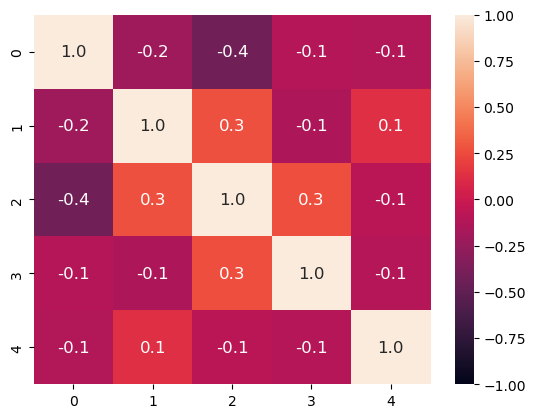

In [4]:
corr_matrix = np.corrcoef(data, rowvar=False)
#выведем матрицу
print('Корреляционная матрица:')
print(corr_matrix)
print('-'*63)
#визуализируем матрицу
print('Визуализация:')
sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True, fmt=".1f", annot_kws={"size": 12})

Можем заметить, что для пар признаков (0,2) и (1,2) наблюдается слабая корреляция. Для остальных признаков корреляция практически отсутствует.

Для выявления аномалий в данных проанализируем распределения каждого из признаков.

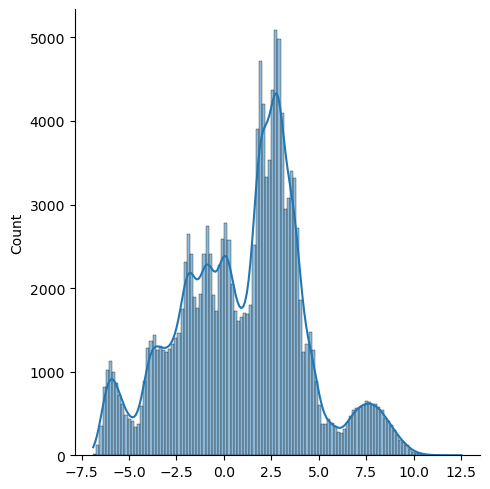

In [5]:
#Первый признак
sns.displot(data[:,0], kde=True)

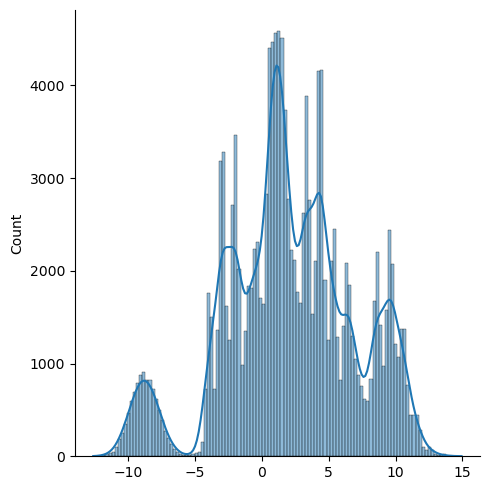

In [6]:
#Второй признак
sns.displot(data[:,1], kde=True)

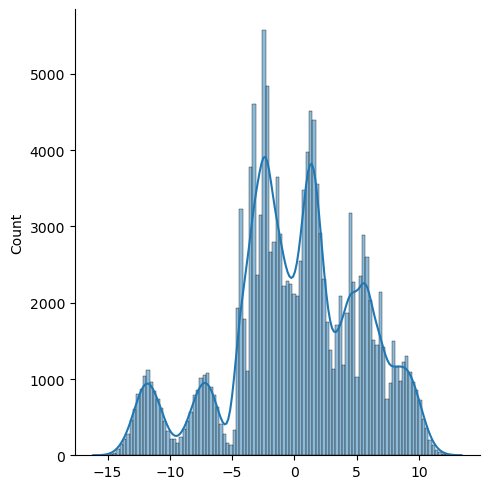

In [7]:
#Третий признак
sns.displot(data[:,2], kde=True)

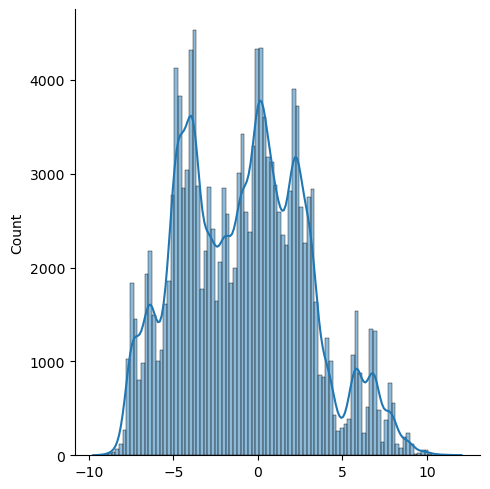

In [8]:
#Четвёртый признак
sns.displot(data[:,3], kde=True)

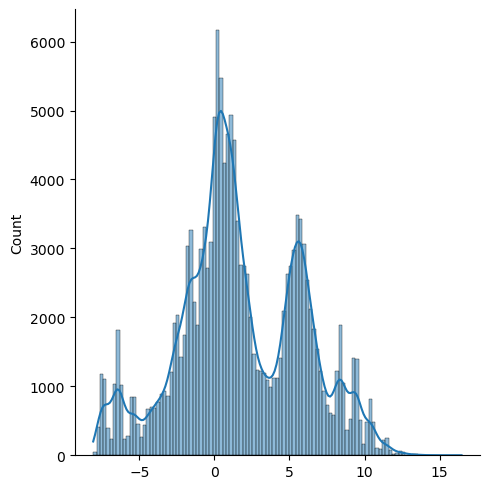

In [9]:
#Пятый признак
sns.displot(data[:,4], kde=True)

Можно видеть, что распределение признаков имеет сложный вид, который можно представить суммой нормальных распределений. 

Отсюда же видно, почему у некоторых признаков имеется слабая корреляция: центры некоторых гауссианов достаточно близки друг к другу.

Распределения получились несимметричными. Для каждого из признаков выбросы не наблюдаются. По порядку величины все признаки распределены в одинаковом диапазоне, предобработка не требуется.

### Метод ближайшего соседа

Реализуем кластеризацию данным методом. Реализация находится в ```clustering.py```

Суть кластеризации основана на том, что постепенно объединяются в кластеры ближайшие пары элементов. Затем процесс повторяется для первых кластеров и так далее. Своего рода получается структура двоичного дерева. 

Дерево будем строить следующим образом. В листьях дерева будут находиться индексы элементов из датасета, а во всех остальных узлах будем хранить расстояние от кластеров, которые имеют общий корень

Попробуем применить кластеризацию на части датасета, так как полностью он слишком большой и кластеризация займёт много времени

In [10]:
import clustering
import matplotlib.pyplot as plt

In [11]:
root = clustering.single_linkage(data[:10])

В файле ```clustering.py``` есть метод, позволяющий отрисовать бинарное дерево, вот его пример в виде готовой картинки:

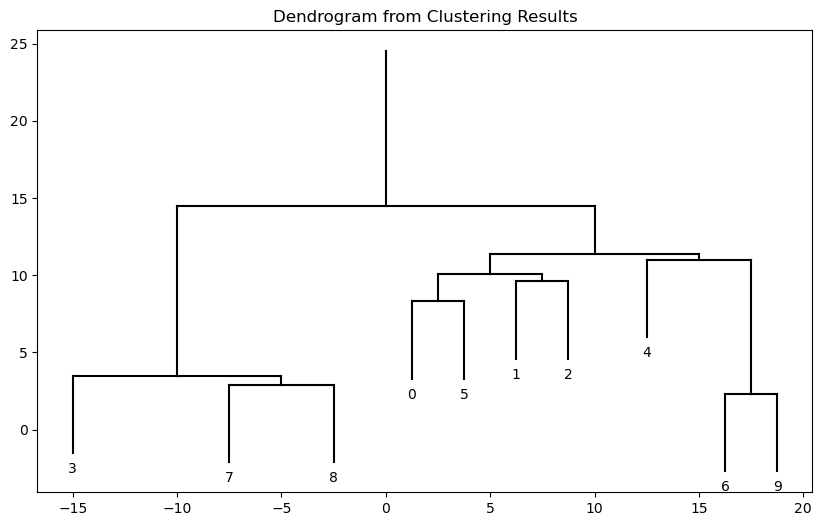

In [12]:
plt.figure(figsize=(10, 6))
plt.title('Dendrogram from Clustering Results')

clustering.plot_u_dendrogram(root)

plt.show()

В листьях расположены индексы элементов из датасета, высота, на которой находится узел, отвечает за расстояние между двумя кластерами. Например, расстояние между двумя крупнейшими кластерами практически равно 15

Как можно видеть, примерно различимую структуру можно нарисовать всего только для порядка десяти сэмплов.

Строить весь датасет будет непрактично по трём причинам:

1. Долгий процесс кластеризации
2. Долгий процесс отрисовки
3. Дерево будет выглядить очень плохо из-за того, что чем ниже оно идёт, тем меньше визуальное расстояние между ними, все вершины будут накладываться


### Метод дальнейшего соседа

In [13]:
root = clustering.complete_linkage(data[:10])

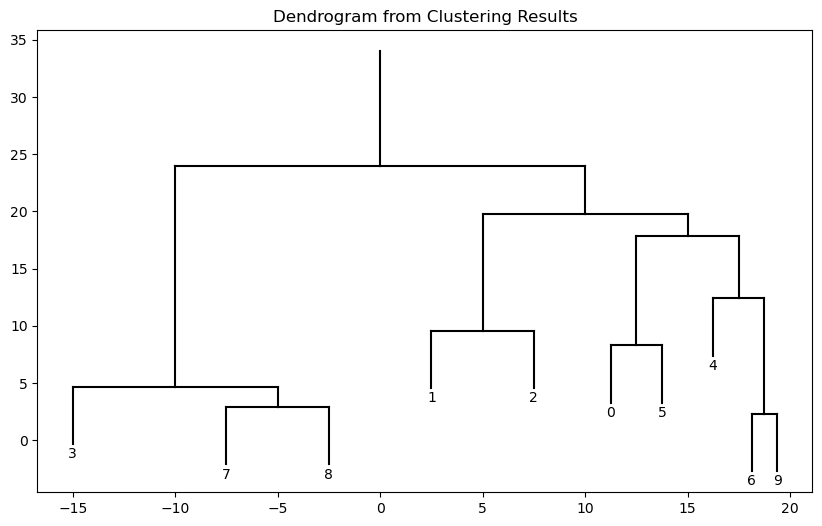

In [14]:
plt.figure(figsize=(10, 6))
plt.title('Dendrogram from Clustering Results')

clustering.plot_u_dendrogram(root)

plt.show()

Метод аналогичен ближайшему, только мы заменяем критерий минимального расстояния между кластерами на максимальный

Посмотрим на пример кластеризации для тех же десяти сэмплов

Структура немного изменилась

Нам также необходимо визуализировать данные после кластеризации. Визуализировать проще всего двумерные данные, так что сперва преобразуем их.

Проведём PCA анализ

In [15]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [16]:
feat_num = data.shape[1]
var_ratio = np.zeros(feat_num)
for num in np.arange(1, feat_num + 1):
    pca = PCA(num)
    pca.fit(data)
    var_ratio[num - 1] = np.sum(pca.explained_variance_ratio_)

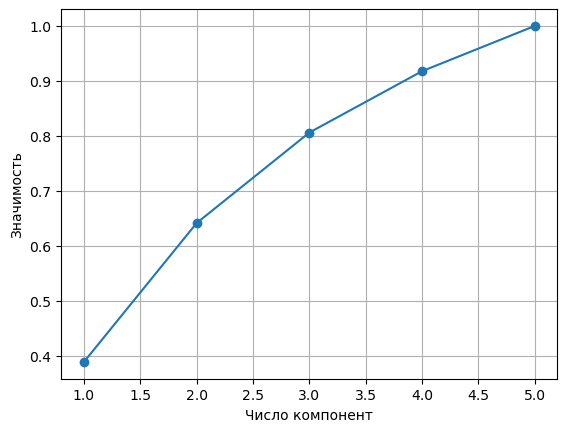

In [17]:
fig, ax = plt.subplots()
plt.plot(np.arange(1, feat_num + 1), var_ratio, '-o')
plt.xlabel('Число компонент')
plt.ylabel('Значимость')
plt.grid()

Важно отметить, что при сокращении количества признаков до двух мы теряем очень много информации. Но двумерная репрезентация данных является самой простой для визуализации

In [18]:
pca = PCA(2)
pca.fit(data)
compressed_data = pca.fit_transform(data)

df = pd.DataFrame(compressed_data, columns=['x', 'y'])

<Axes: xlabel='x', ylabel='y'>

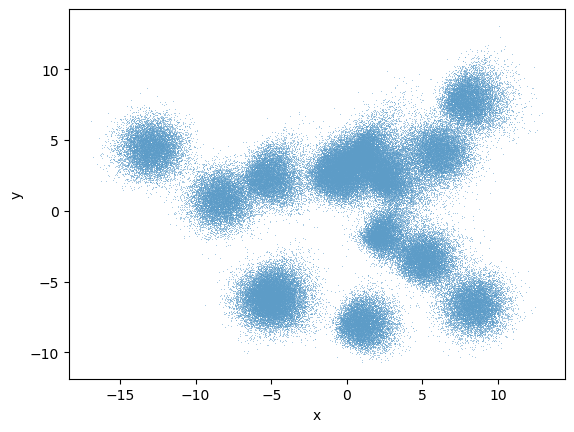

In [19]:
sns.scatterplot(data=df, x ='x', y='y', s=0.3)

Визуально можно выделить 11 кластеров

Проведём полную кластеризацию данных. Весь массив данных обработать не получится, возьмём случайную долю из датасета

In [24]:
n = int(compressed_data.shape[0] / 200)
indices = np.random.choice(compressed_data.shape[0], n, replace=False)
k = 11

In [25]:
cluster_single = clustering.single_linkage(compressed_data[indices])
single_labels = clustering.bfs_k_classes_split(cluster_single, k)

In [26]:
cluster_complete = clustering.complete_linkage(compressed_data[indices])
complete_labels = clustering.bfs_k_classes_split(cluster_complete, k)

In [27]:
small_df_single = pd.DataFrame(compressed_data[indices])
small_df_single['label'] = single_labels

In [28]:
small_df_complete = pd.DataFrame(compressed_data[indices])
small_df_complete.rename(index={0: 'x', 1: 'y'})
small_df_complete['label'] = complete_labels

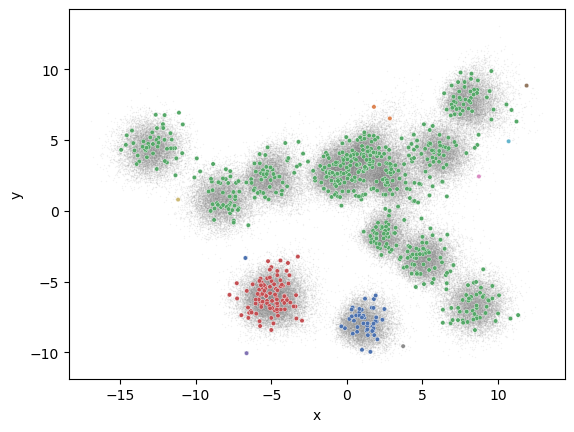

In [29]:
all_data = sns.scatterplot(data=df, color='gray', x='x', y='y', s = 1, alpha=0.1)
ax = sns.scatterplot(data=small_df_single, x =0, y=1, hue='label', palette='deep', s=10)
ax.get_legend().remove()

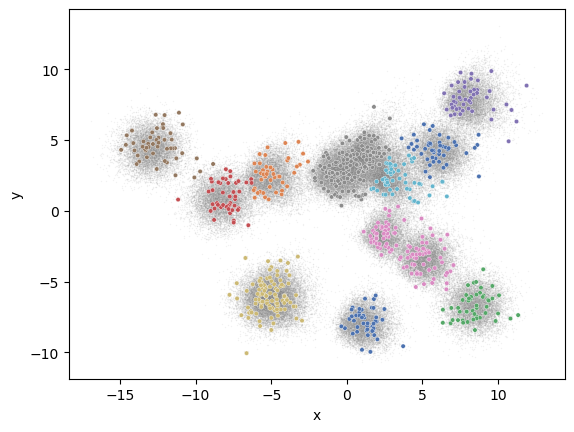

In [30]:
all_data = sns.scatterplot(data=df, color='gray', x='x', y='y', s = 1, alpha=0.1)
ax = sns.scatterplot(data=small_df_complete, x =0, y=1, hue='label', palette='deep', s=10)
ax.get_legend().remove()

Можем увидеть, что в случае дальнейшего соседа кластеризация проведедена лучше, в ближайшем соседе слишком много данных попало в один кластер, хотя визуально они достаточно удалены друг от друга.

Оценим нащи кластеризации по трём метрикам

### Сумма квадратов расстояний до центров классов

Данная метрика задаётся формулой 

$$
    F_1 = \sum\limits_m \sum\limits_{i \in S_m} d^2(x_i, \mu_m),
$$
где $m$ - номер кластера, $\mu_m$ - центр $m$-го кластера

### k-средних

Реализуем метод кластеризации, основнный на минимизации суммы квадратов внутрикластерных расстояний в методе ```k_means```, который принимает на вход датасет, количество кластеров

In [31]:
labels = clustering.k_means(compressed_data, k=10, averaging=1)

In [32]:
df['label'] = labels

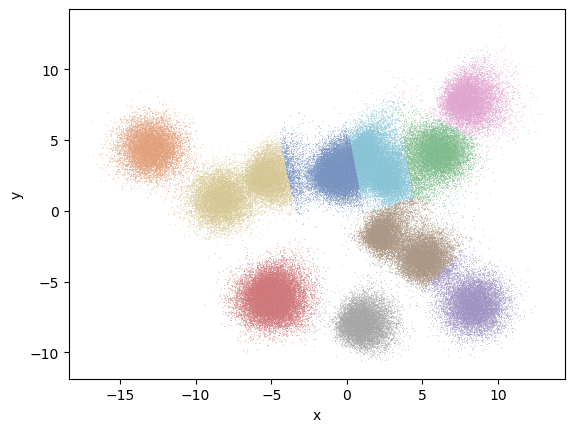

In [33]:
ax = sns.scatterplot(data=df, x ='x', y='y', hue='label', palette='deep', s=0.3)
ax.get_legend().remove()

Видно, что результат неидеальный, как минимум потому, что предположение о количестве классов мы сделали "на глаз", при этом рассматривали сжатые данные, в которых много информации утеряно

Разделим данные в отдельные кластеры

In [34]:
grouped = df.groupby('label')

label_arrays = {}
for label, group in grouped:
    label_arrays[label] = group[['x', 'y']].to_numpy()
